### Car or not

In [2]:
import urllib
from IPython.display import Image, display, clear_output
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import json
import pickle as pk
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
import os
import h5py
import numpy as np
import pandas as pd

from keras.utils.data_utils import get_file
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
from keras import optimizers
from keras.callbacks import ModelCheckpoint, History

Using TensorFlow backend.


In [4]:
CLASS_INDEX = None
CLASS_INDEX_PATH = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'

In [5]:
#Getting the predictions
def get_predictions(preds, top=5):
    global CLASS_INDEX
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects '
                         'a batch of predictions '
                         '(i.e. a 2D array of shape (samples, 1000)). '
                         'Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        fpath = get_file('imagenet_class_index.json',
                         CLASS_INDEX_PATH,
                         cache_subdir='models')
        CLASS_INDEX = json.load(open(fpath))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results

In [6]:
vgg16 = VGG16(weights='imagenet')

In [7]:
vgg16.save('vgg16.h5')

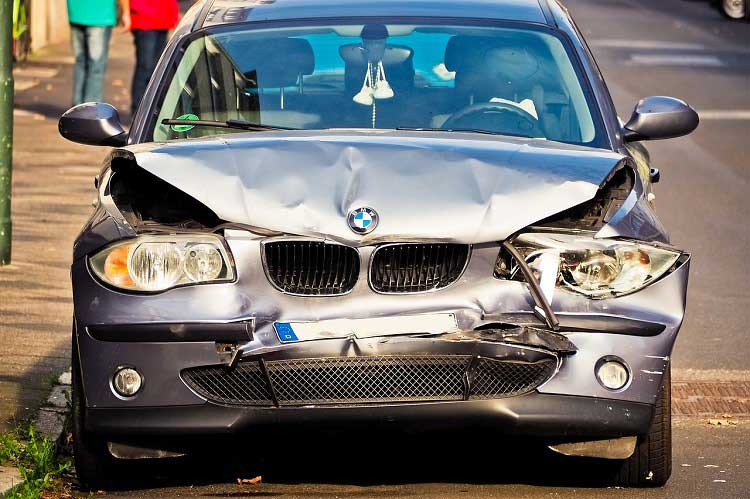

In [8]:
Image('car.jpg', width=200)

In [9]:
def prepare_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

## Testing 

In [10]:
y = prepare_image('car.jpg')
preds = vgg16.predict(y)
print (get_predictions(preds, top=5))


[[('n03459775', 'grille', 0.35639265), ('n03770679', 'minivan', 0.2458625), ('n02814533', 'beach_wagon', 0.061850715), ('n03930630', 'pickup', 0.060355462), ('n04285008', 'sports_car', 0.050138894)]]


## Find car categories 

In [11]:
def get_car_categories():
    d = defaultdict(float)
    img_list = os.listdir('data0')
    for i, img_path in enumerate(img_list):
        img = prepare_image('data0/'+img_path)
        out = vgg16.predict(img)
        top = get_predictions(out, top=5)
        for j in top[0]:
            d[j[0:2]] += j[2]
        if i % 50 == 0:
            print (i, '/', len(img_list), 'complete')
    return Counter(d)

In [23]:
cat_counter = get_car_categories()

0 / 1298 complete
50 / 1298 complete
100 / 1298 complete
150 / 1298 complete
200 / 1298 complete
250 / 1298 complete
300 / 1298 complete
350 / 1298 complete
400 / 1298 complete
450 / 1298 complete
500 / 1298 complete
550 / 1298 complete
600 / 1298 complete
650 / 1298 complete
700 / 1298 complete
750 / 1298 complete
800 / 1298 complete
850 / 1298 complete
900 / 1298 complete
950 / 1298 complete
1000 / 1298 complete
1050 / 1298 complete
1100 / 1298 complete
1150 / 1298 complete
1200 / 1298 complete
1250 / 1298 complete


In [24]:
with open('cat_counter.pk', 'wb') as f:
    pk.dump(cat_counter,f,-1)

### Load Pickle Point

In [12]:
with open('cat_counter.pk', 'rb') as f:
    cat_counter = pk.load(f)

In [13]:
cat_list = [k for k, v in cat_counter.most_common()[:5]] #la liste des catégories

## Implementation

In [14]:
def car_categories_gate(image_path, cat_list):
    img = prepare_image(image_path)
    out = vgg16.predict(img)
    top = get_predictions(out, top=5)
    print ("Validating that this is a picture of your car...")
    for j in top[0]:
        if j[0:2] in cat_list:
            print (j[0:2])
            return "Validation complete - proceed to damage evaluation"
    return "Are you sure this is a picture of your car? Please take another picture (try a different angle or lighting) and try again."

In [15]:
car_categories_gate('car.jpg', cat_list)

Validating that this is a picture of your car...
('n03770679', 'minivan')


'Validation complete - proceed to damage evaluation'

In [16]:
car_categories_gate('cat.jpg', cat_list)

Validating that this is a picture of your car...


'Are you sure this is a picture of your car? Please take another picture (try a different angle or lighting) and try again.'

In [17]:
car_categories_gate('camion.jpg', cat_list)

Validating that this is a picture of your car...


'Are you sure this is a picture of your car? Please take another picture (try a different angle or lighting) and try again.'